In [ ]:
!pip install datasets rouge_score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.6/301.6 kB 26.5 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=b779fb8d80bdf7984df29308e230628d4db536992

In [ ]:
import numpy as np
import gensim.downloader as api
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, GRU, Bidirectional, Conv1D, MaxPooling1D, TimeDistributed, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from datasets import load_dataset
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [ ]:
# Parameters
max_len_input = 100
max_len_target = 50
latent_dim = 256
embedding_dim = 300  # As per Word2Vec dimensions
dataset_name = "allenai/multinews_dense_oracle"
batch_size = 64
epochs = 10


In [ ]:
# Load datasets
dataset = load_dataset(dataset_name)
dataset_train = dataset['train'].select(range(1000))  # Using smaller data for example
dataset_val = dataset['validation'].select(range(1000))
dataset_test = dataset['test'].select(range(1000))

Generating train split:   0%|          | 0/44972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5622 [00:00<?, ? examples/s]

In [ ]:
print(dataset_train.shape)

(1000, 2)


In [ ]:
# Prepare data
def prepare_data(dataset):
    input_texts = [str(data['document']) for data in dataset]
    target_texts = ["\t " + str(data['summary']) + " \n" for data in dataset]
    return input_texts, target_texts

In [ ]:
train_input_texts, train_target_texts = prepare_data(dataset_train)
val_input_texts, val_target_texts = prepare_data(dataset_val)
test_input_texts, test_target_texts = prepare_data(dataset_test)

In [ ]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_input_texts + train_target_texts + val_input_texts + val_target_texts)
vocab_size = len(tokenizer.word_index) + 1


In [ ]:
print(vocab_size)

100346


In [ ]:
word2vec = api.load("word2vec-google-news-300")

[======--------------------------------------------] 13.9% 231.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 15.6% 260.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========-----------------------------------------] 19.0% 315.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========----------------------------------------] 20.7% 344.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========---------------------------------------] 22.5% 374.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============--------------------------------------] 24.3% 403.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============-------------------------------------] 26.0% 432.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============-------------------------------------] 27.7% 461.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============------------------------------------] 29.8% 495.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============-----------------------------------] 31.5% 523.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================----------------------------------] 33.2% 552.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 35.0% 581.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================--------------------------------] 36.7% 610.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================-------------------------------] 38.5% 640.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================------------------------------] 40.3% 669.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====================-----------------------------] 42.0% 698.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====================-----------------------------] 43.8% 728.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================----------------------------] 45.6% 757.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================--------------------------] 48.1% 799.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================--------------------------] 49.8% 828.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================-------------------------] 51.5% 856.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================------------------------] 53.2% 885.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================---------------------] 58.9% 980.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================--------------------] 60.7% 1008.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================-------------------] 62.4% 1037.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================------------------] 64.1% 1066.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================------------------] 65.9% 1095.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================-----------------] 67.6% 1124.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================----------------] 69.4% 1154.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================================---------] 83.9% 1394.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================================-----] 91.7% 1524.1/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================================----] 93.5% 1554.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================================---] 95.2% 1583.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================================================--] 96.9% 1612.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
#creation of embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [ ]:
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass


In [ ]:
embedding_matrix.shape

(100346, 300)

In [ ]:
embedding_vector.shape

(300,)

In [ ]:
# Helper function to convert and pad sequences
def process_texts(input_texts, target_texts):
    input_sequences = tokenizer.texts_to_sequences(input_texts)
    target_sequences = tokenizer.texts_to_sequences(target_texts)
    input_sequences = pad_sequences(input_sequences, maxlen=max_len_input, padding='post')
    target_sequences = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
    return input_sequences, target_sequences


In [ ]:
input_sequences, target_sequences = process_texts(train_input_texts, train_target_texts)
val_input_sequences, val_target_sequences = process_texts(val_input_texts, val_target_texts)
test_input_sequences, test_target_sequences = process_texts(test_input_texts, test_target_texts)


In [ ]:
# Decoder input and target data
decoder_input_data = target_sequences[:, :-1]
decoder_target_data = target_sequences[:, 1:]
decoder_target_data_one_hot = to_categorical(decoder_target_data, num_classes=vocab_size)

val_decoder_input_data = val_target_sequences[:, :-1]
val_decoder_target_data = val_target_sequences[:, 1:]
val_decoder_target_data_one_hot = to_categorical(val_decoder_target_data, num_classes=vocab_size)

test_decoder_input_data = test_target_sequences[:, :-1]
test_decoder_target_data = test_target_sequences[:, 1:]
test_decoder_target_data_one_hot = to_categorical(test_decoder_target_data, num_classes=vocab_size)


In [ ]:
# Define the model

# Encoder
encoder_inputs = Input(shape=(max_len_input,))
encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(encoder_inputs)
encoder_conv = Conv1D(filters=latent_dim, kernel_size=3, activation='relu', padding='same')(encoder_embedding)
encoder_pool = MaxPooling1D(pool_size=2)(encoder_conv)
encoder_gru = GRU(latent_dim, return_state=True)
encoder_outputs, state_h = encoder_gru(encoder_pool)
encoder_states = [state_h]

In [ ]:
# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding_layer = Embedding(input_dim=vocab_size, output_dim=latent_dim)
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_bigru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=False))
decoder_outputs = decoder_bigru(decoder_embedding, initial_state=encoder_states + encoder_states)  # Adjust initial_state
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Checkpoint callback
checkpoint_path = "model_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


In [ ]:
# Training the model
history = model.fit(
    [input_sequences, decoder_input_data],
    decoder_target_data_one_hot,  # one-hot encoded labels
    batch_size=batch_size,
    epochs=50,
    validation_data=([val_input_sequences, val_decoder_input_data], val_decoder_target_data_one_hot),  # corrected validation data
    callbacks=[checkpoint],
    verbose=1
)


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 11.0353 - accuracy: 0.0659
Epoch 1: val_loss improved from inf to 8.12064, saving model to model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 86s 5s/step - loss: 11.0353 - accuracy: 0.0659 - val_loss: 8.1206 - val_accuracy: 0.0579
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 7.7831 - accuracy: 0.0600
Epoch 2: val_loss did not improve from 8.12064
16/16 [==============================] - 49s 3s/step - loss: 7.7831 - accuracy: 0.0600 - val_loss: 8.2182 - val_accuracy: 0.0579
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 7.4316 - accuracy: 0.0600
Epoch 3: val_loss improved from 8.12064 to 8.09489, saving model to model_checkpoint.h5
16/16 [==============================] - 51s 3s/step - loss: 7.4316 - accuracy: 0.0600 - val_loss: 8.0949 - val_accuracy: 0.0579
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 7.3157 - accuracy: 0.0601
Epoch 4: val_loss improved from 8.09489 to 8.08018, saving model to model_checkpoint.h5
16/16 [==============================] - 51s 3s/step - loss: 7.3157 - accuracy: 0.0601 - val_loss: 8.0802 -

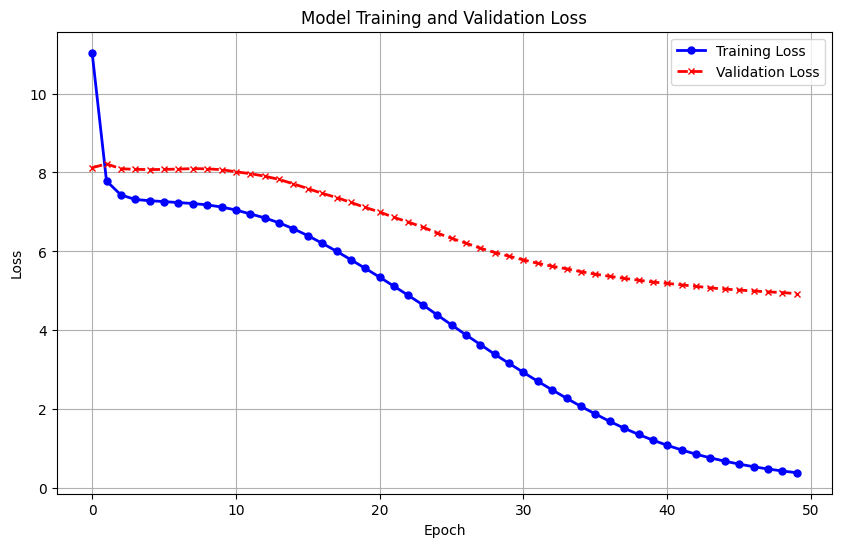

In [ ]:
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Plot training & validation loss with specific line style and marker
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-', marker='o', linewidth=2, markersize=5)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--', marker='x', linewidth=2, markersize=5)

# Add title and axis labels
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add grid
plt.grid(True)

# Add legend to specify which line is which
plt.legend()

# Show the plot
plt.show()

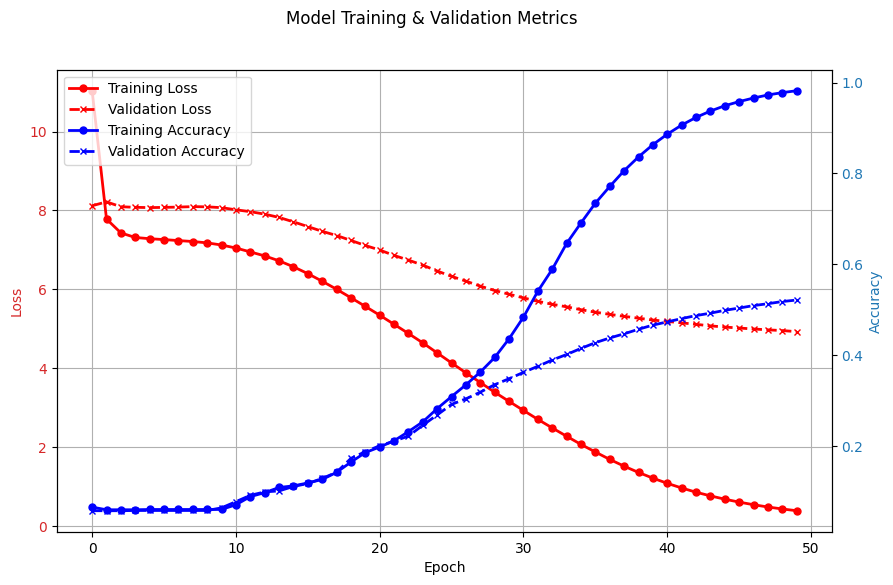

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training and validation loss
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
loss_train_line, = ax1.plot(history.history['loss'], label='Training Loss', color='red', linestyle='-', marker='o', linewidth=2, markersize=5)
loss_val_line, = ax1.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--', marker='x', linewidth=2, markersize=5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Instantiate a second y-axis for same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
accuracy_train_line, = ax2.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linestyle='-', marker='o', linewidth=2, markersize=5)
accuracy_val_line, = ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue', linestyle='--', marker='x', linewidth=2, markersize=5)
ax2.tick_params(axis='y', labelcolor=color)

# Create a legend for all lines
lines = [loss_train_line, loss_val_line, accuracy_train_line, accuracy_val_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Add a title to the figure
fig.suptitle('Model Training & Validation Metrics')

# Show the plot
plt.show()


In [ ]:
# Load the best model
model.load_weights('model_checkpoint.h5')


NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd

def evaluate_average_rouge(model, input_data, decoder_input_data, target_data, tokenizer):
    # Generate predictions
    pred_one_hot = model.predict([input_data, decoder_input_data])
    pred_labels = np.argmax(pred_one_hot, axis=-1)

    # Convert predictions and true labels to texts
    true_texts = [' '.join(tokenizer.sequences_to_texts([seq])) for seq in target_data.argmax(axis=-1)]
    pred_texts = [' '.join(tokenizer.sequences_to_texts([seq])) for seq in pred_labels]

    # Initialize the ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    all_scores = [scorer.score(true, pred) for true, pred in zip(true_texts, pred_texts)]

    # Calculate average scores
    average_scores = {key: {'precision': 0, 'recall': 0, 'fmeasure': 0} for key in ['rouge1', 'rouge2', 'rougeL']}
    for score in all_scores:
        for key in score:
            average_scores[key]['precision'] += score[key].precision
            average_scores[key]['recall'] += score[key].recall
            average_scores[key]['fmeasure'] += score[key].fmeasure

    # Average the summed scores
    num_scores = len(all_scores)
    for key in average_scores:
        average_scores[key]['precision'] /= num_scores
        average_scores[key]['recall'] /= num_scores
        average_scores[key]['fmeasure'] /= num_scores

    # Convert to DataFrame for display
    df = pd.DataFrame(average_scores).transpose()
    df.columns = ['Precision', 'Recall', 'F-measure']
    return df

# Example usage
average_rouge_scores = evaluate_average_rouge(model, test_input_sequences, test_decoder_input_data, test_decoder_target_data_one_hot, tokenizer)
print("Average ROUGE Scores:")
print(average_rouge_scores)


32/32 [==============================] - 6s 201ms/step
Average ROUGE Scores:
        Precision    Recall  F-measure
rouge1   0.540949  0.534917   0.537843
rouge2   0.280377  0.277224   0.278752
rougeL   0.535763  0.529788   0.532686


In [ ]:
import numpy as np
from rouge_score import rouge_scorer
import pandas as pd

def evaluate_rouge_scores(model, input_data, decoder_input_data, target_data, tokenizer):
    # Prediction
    pred_one_hot = model.predict([input_data, decoder_input_data])
    pred_labels = np.argmax(pred_one_hot, axis=-1)

    # Convert labels to text using the tokenizer
    true_texts = [' '.join(tokenizer.sequences_to_texts([seq])) for seq in target_data.argmax(axis=-1)]
    pred_texts = [' '.join(tokenizer.sequences_to_texts([seq])) for seq in pred_labels]

    # Initialize ROUGE scorer, including ROUGE-S
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'], use_stemmer=True)
    scores = [scorer.score(t, p) for t, p in zip(true_texts, pred_texts)]

    # Prepare data for display
    results = []
    for score_dict in scores:
        row = {}
        for key, value in score_dict.items():
            row[f'{key}_precision'] = value.precision
            row[f'{key}_recall'] = value.recall
            row[f'{key}_fmeasure'] = value.fmeasure
        results.append(row)

    # Convert list of dicts to DataFrame for easy visualization
    results_df = pd.DataFrame(results)
    average_results = results_df.mean()

    return average_results

# Example usage
average_rouge_scores = evaluate_rouge_scores(model, test_input_sequences, test_decoder_input_data, test_decoder_target_data_one_hot, tokenizer)
print("Average ROUGE Scores:")
print(average_rouge_scores.to_string())


32/32 [==============================] - 6s 200ms/step
Average ROUGE Scores:
rouge1_precision       0.540949
rouge1_recall          0.534917
rouge1_fmeasure        0.537843
rouge2_precision       0.280377
rouge2_recall          0.277224
rouge2_fmeasure        0.278752
rougeL_precision       0.535763
rougeL_recall          0.529788
rougeL_fmeasure        0.532686
rougeLsum_precision    0.535763
rougeLsum_recall       0.529788
rougeLsum_fmeasure     0.532686


In [ ]:
def generate_summary(input_text, tokenizer, model, max_len_input, max_len_target):
    # Preprocess the input text (tokenization and padding)
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_len_input, padding='post')

    # Initialize the sequence for the output summary with the start token
    start_token, stop_token = '<start>', '<end>'
    start_token_idx = tokenizer.word_index.get(start_token, 1)  # Default to 1 if not found
    stop_token_idx = tokenizer.word_index.get(stop_token, 2)  # Default to 2 if not found

    # Start with the start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = start_token_idx

    # Initialize summary with empty list
    summary = []

    for i in range(max_len_target):
        # Predict the next word
        output_tokens = model.predict([input_seq, target_seq])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tokenizer.index_word[sampled_token_index] if sampled_token_index > 0 else None

        # Check for stop condition: either hit stop token or max length
        if sampled_token == stop_token or sampled_token is None:
            break

        # Append the token as part of the summary
        summary.append(sampled_token)

        # Update the target sequence (of length 1) to be the token just generated
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

    return ' '.join(summary)

# Example usage:
new_document = "My Name is abhinay"
summary = generate_summary(new_document, tokenizer, model, max_len_input, max_len_target)
print("Generated Summary:")
print(summary)


1/1 [==============================] - 0s 33ms/step
Generated Summary:
polls regulations sense here fingers sense here fingers sense here fingers sense here fingers sense here fingers sense here fingers sense here fingers sense here fingers sense here fingers sense here fingers sense here fingers sense here fingers sense here fingers sense here fingers sense here fingers sense here fingers


In [ ]:
import numpy as np

def generate_summary(input_text, tokenizer, model, max_len_input, max_len_target, temperature=1.0):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_len_input, padding='post')

    start_token_idx = tokenizer.word_index.get('<start>', 1)
    target_seq = np.array([[start_token_idx]])

    summary = []

    for i in range(max_len_target):
        predictions = model.predict([input_seq, target_seq])[0, -1, :]
        predictions = np.log(predictions) / temperature
        exp_predictions = np.exp(predictions)
        predictions = exp_predictions / np.sum(exp_predictions)
        sampled_token_index = np.random.choice(len(predictions), p=predictions)

        if sampled_token_index == tokenizer.word_index.get('<end>', 2):
            break

        sampled_token = tokenizer.index_word.get(sampled_token_index, None)
        summary.append(sampled_token)

        target_seq = np.array([[sampled_token_index]])

    return ' '.join(summary)

# Adjust 'temperature' as needed (values >1.0 increase diversity, <1.0 make outputs more deterministic)
summary = generate_summary(new_document, tokenizer, model, max_len_input, max_len_target, temperature=0.8)
print("Generated Summary:")
print(summary)


1/1 [==============================] - 0s 34ms/step
Generated Summary:
polls pilot pilot donations averages regulations tweet quickly loves fingers suspended carolina sense patients gagnon regulations fingers suing invasion regulations immediately permanently regulations immediately sense suing manager fingers here regulations moms changes pilot regulations pilot fingers carolina regulations fingers prisons gagnon sense wasn't often fingers polls pilot loves pilot minutes


In [ ]:
# Load text from 'testdoc.txt'
with open('testdoc.txt', 'r', encoding='utf-8') as file:
    testdoc_text = file.read()

# Preprocess the text
testdoc_sequence = tokenizer.texts_to_sequences([testdoc_text])
padded_testdoc_sequence = pad_sequences(testdoc_sequence, maxlen=max_len_input, padding='post')

# Generate a summary
test_decoder_input = np.zeros((1, 1))
summary = ""
for _ in range(max_len_target):
    output_tokens = model.predict([padded_testdoc_sequence, test_decoder_input])
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = tokenizer.index_word[sampled_token_index]
    summary += ' ' + sampled_char
    test_decoder_input = np.array([[sampled_token_index]])
    if sampled_char == '\n':
        break

print("Generated summary:", summary)

1/1 [==============================] - 0s 33ms/step
Generated summary:  sense here minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes minutes
